# Week 8 - Advanced Machine Learning

## Reinforcement learning

Reinforcement learning focuses on adapting the behaviour of an agent in a particular environment such that the cumulative reward is maximized.

Inputs are not paired with correct outputs leaving the algorithm to estimate the utility of any action based on experience. There is a trade-off between taking an action that has had a positive outcome in the past and trying alternative actions that may have higher rewards.

The important point here is that taking the optimal action can have no reward, and taking an inferior action can have a positive reward. Knowing which is which only becomes clear with multiple trials.

Reinforcement learning is used in game playing such as [AlphaGo](https://en.wikipedia.org/wiki/AlphaGo), robot control, optimizing resource utilization, recommendations, etc.

The important point in all these systems is that taking the optimal action can have no reward, and taking an inferior action can have a positive reward. Knowing which is which only becomes clear with multiple trials.

This trade-off is perhaps most widely studied in multi-armed bandit problems.

### Optimizing for page views

As an example, let's suppose we are an online publisher generating revenue from advertising. The more page views we get the more money we make. On each page we will put a list of articles we hope the viewer will like and hopefully click, generating revenue. But how do we choose which articles to show?

This is an ideal situation for using a multi-armed bandit algorithm. As a simple example, we might have 20 articles from which we can choose one.

One approach would be to show each article to a thousand people picked at random, record how many clicks each receive, and then show the article with the highest number to all future visitors.

If after 100 visitors one article has received zero clicks should we persist and show it to a further 900 visitors? Or, are we throwing away advertising revenue? How about after 200, or 300?

This is the explore-exploit trade-off. We can explore the different options at the risk of losing money during our trials or we can exploit actions we know to be good at the risk of missing out on better returns and stagnating.

### Adaptive clinical trials

Parallels can be made with randomized clinical trials. If instead of page views we have patients, instead of clicks we have survival, and instead of articles we have treatments the situation resembles a randomized trial.

Let's consider a trial with two different treatments. At the beginning of the trial we don't know which is best, and at the end, hopefully, we know one is better than the other. In a conventional trial the last patient enrolled still has an equal chance of being assigned to either treatment, even though we now know much more about the relative efficacy of the two treatments.
    
Adaptive randomization attempts to maximize the benefit of the trial to the participants while maintaining the societal benefit.

There have been a variety of models developed and studied for these trials but we can implement a simple multi-armed bandit algorithm to demonstrate the approach.

The code below runs multiple simulations to explore the behavior of different strategies.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
class Model(object):
    def __init__(self, algo, algo_kwargs, weights=[0.1, 0.1], size=100, repeats=200):
        self.algo = algo
        self.algo_kwargs = algo_kwargs
        self.weights = weights
        self.size = size
        self.repeats = repeats
        
    def run_simulation(self):
        """Run a single simulation, recording the performance"""
        algo = self.algo(**self.algo_kwargs)
        arm_choice_record = []
        reward_record = []
        for i in range(self.size):
            arm = algo.choose_arm()
            arm_choice_record.append(arm)
            reward = np.random.random() < self.weights[arm]
            reward_record.append(reward)
            algo.update(arm, reward)
        return arm_choice_record, reward_record
    
    def repeat_simulation(self):
        """Run multiple simulations, recording the performance of each"""
        arm_choice = []
        reward = []
        for i in range(self.repeats):
            arm_choice_record, reward_record = self.run_simulation()
            arm_choice.append(arm_choice_record)
            reward.append(reward_record)
        self.arm_choice = np.array(arm_choice)
        self.reward = np.array(reward)
        
    def plot_arm_frequency(self, ax, color="k"):
        """Plot the frequency with which the second arm is chosen
        NOTE: Currently only works for two arms"""
        ax.plot(self.arm_choice.mean(axis=0), color)
        ax.set_title('Frequency of arm choice')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Frequency')
        return ax
    
    def plot_reward(self, ax, color='-k'):
        """Plot the average reward for each trial across all simulations"""
        ax.plot(self.reward.mean(axis=0), color)
        ax.set_title('Reward')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Reward')
        return ax
    
    def plot_cumulative_reward(self, ax, color='-k'):
        """Plot the cumulative reward across all simulations"""
        ax.plot(np.cumsum(self.reward, axis=1).mean(axis=0), color)
        ax.set_title('Cumulative Reward')
        ax.set_xlabel('Trial')
        ax.set_ylabel('Cumulative Reward')
        return ax

In [3]:
class RCT(object):
    def __init__(self, n_arms, epsilon):
        self._epsilon = epsilon
        self.counts = [0] * n_arms
        self.values = [0] * n_arms
        self.n_arms = n_arms
    
    def choose_arm(self):
        """Choose an arm"""
        if np.random.random() > self.epsilon:
            weights = np.array(self.values)
            weights = weights == weights.max()
            weights = weights / weights.sum()
            return np.random.choice(np.arange(self.n_arms), p=weights)
        else:
            return np.random.randint(self.n_arms)
        
    
    def update(self, arm, reward):
        """Update an arm with the reward"""
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        value = self.values[arm]
        # Running product
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1/n) * reward
    
    @property
    def epsilon(self):
        if sum(self.counts) < 100:
            return 1
        else:
            return 0

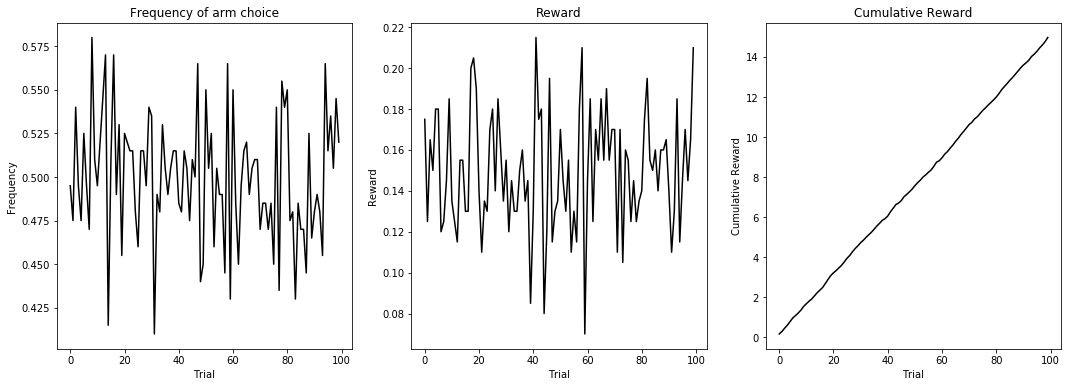

In [4]:
model = Model(RCT, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()

fig, axes = plt.subplots(1,3, figsize=(18,6))
model.plot_arm_frequency(ax=axes[0])
model.plot_reward(ax=axes[1])
model.plot_cumulative_reward(ax=axes[2])

plt.show()

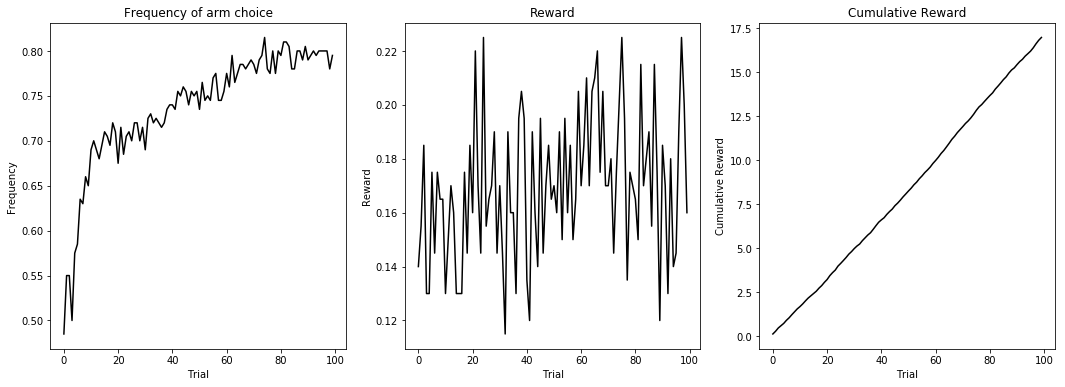

In [5]:
# EpsilonGreedy explores with a fixed probability and exploits the highest rewarding arm otherwise

class EpsilonGreedy(RCT):
    
    @property
    def epsilon(self):
        return self._epsilon

model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()

fig, axes = plt.subplots(1,3, figsize=(18,6))
model.plot_arm_frequency(ax=axes[0])
model.plot_reward(ax=axes[1])
model.plot_cumulative_reward(ax=axes[2])

plt.show()

Exploring the performance further will benefit from a reorganization of the code

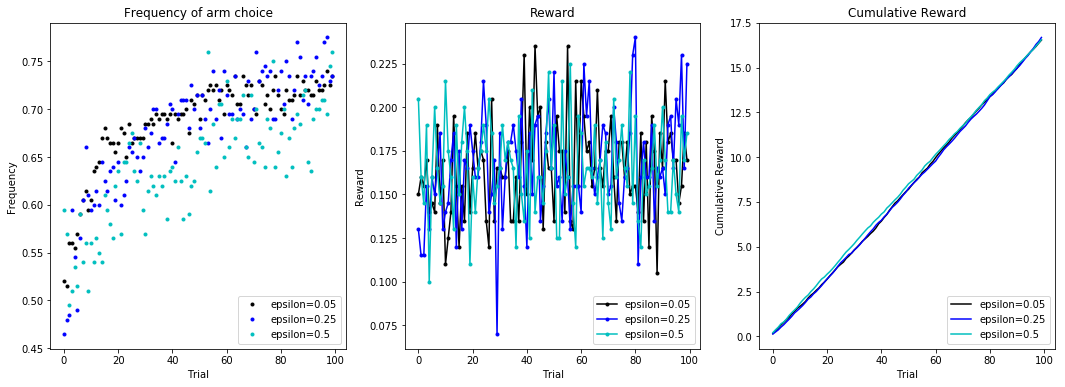

In [6]:
def plot_arm_frequency(simulation, ax, marker='.', linestyle='', color='k', label=''):
    """Plot the frequency with which the second arm is chosen
    NOTE: Currently only works for two arms"""
    ax.plot(simulation.arm_choice.mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Frequency of arm choice')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Frequency')
    return ax
    
def plot_reward(simulation, ax, marker='.', linestyle='-', color='k', label=''):
    """Plot the average reward for each trial across all simulations"""
    ax.plot(simulation.reward.mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Reward')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Reward')
    return ax
    
def plot_cumulative_reward(simulation, ax, marker='', linestyle='-', color='k', label=''):
    """Plot the cumulative reward across all simulations"""
    ax.plot(np.cumsum(simulation.reward, axis=1).mean(axis=0), 
            marker=marker, linestyle=linestyle, color=color, label=label)
    ax.set_title('Cumulative Reward')
    ax.set_xlabel('Trial')
    ax.set_ylabel('Cumulative Reward')
    return ax

def plot_summary(model, axes, color='', label=''):
    plot_arm_frequency(model, ax=axes[0], color=color, label=label)
    plot_reward(model, ax=axes[1], color=color, label=label)
    plot_cumulative_reward(model, ax=axes[2], color=color, label=label)
    for ax in axes:
        ax.legend(loc=4)
    return axes



fig, axes = plt.subplots(1,3, figsize=(18,6))


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.25}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='b', label='epsilon=0.25')


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.5}, weights=[0.1, 0.2])
model.repeat_simulation()
plot_summary(model, axes, color='c', label='epsilon=0.5')


plt.show()

An Adaptive Epsilon Greedy algorithm is another option and should change the value of epsilon (and the likelihood of choosing randomly) as the number of trials increase. There are many ways this could be implemented:

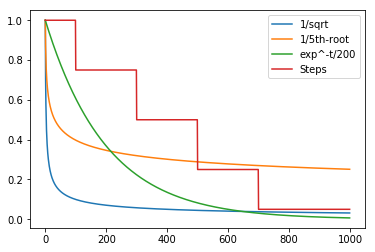

In [7]:
t = np.arange(1000)
plt.plot(t, (1+t)**-0.5, label='1/sqrt')
plt.plot(t, (1+t)**-0.2, label='1/5th-root')
plt.plot(t, np.exp(-(t/200.)), label='exp^-t/200')

u = np.concatenate((np.ones(100), 
                    np.ones(200) * 0.75, 
                    np.ones(200) * 0.5, 
                    np.ones(200) * 0.25,
                    np.ones(300) * 0.05))
plt.plot(t,u, label='Steps')
plt.legend()
plt.show()

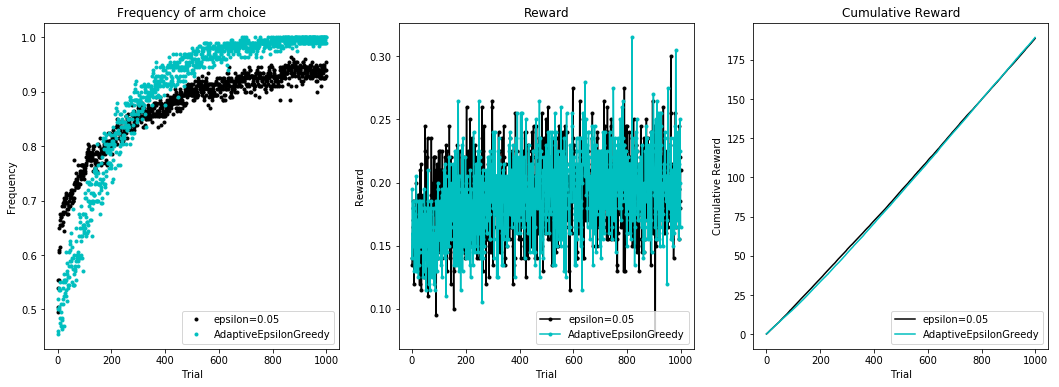

In [8]:
class AdaptiveEpsilonGreedy(RCT):
    
    @property
    def epsilon(self):
        return self._epsilon * np.exp(-(sum(self.counts)/200.))
    
    
    
fig, axes = plt.subplots(1,3, figsize=(18,6))


model = Model(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=1000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = Model(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=1000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')

plt.show()

The falling epsilon value means the AdaptiveEpsilonGreedy algorithm will explore less and less of the time, instead exploiting the arm it knows to be best. This has advantages and disadvantages. If the environment is stable the cumulative reward will be higher but it will be very slow to respond to any changes.

For example, if the rewards for the two arms were to switch:

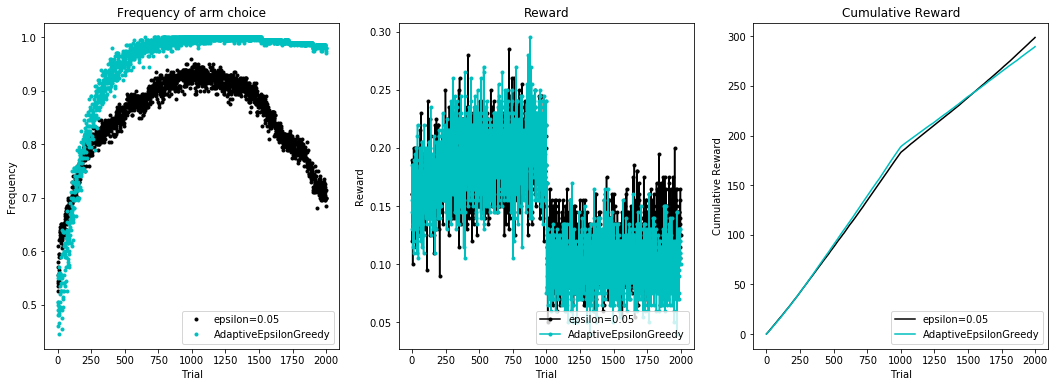

In [9]:
class DynamicModel(object):
    def __init__(self, algo, algo_kwargs, weights=[0.1, 0.1], size=100, repeats=200):
        self.algo = algo
        self.algo_kwargs = algo_kwargs
        self.weights = weights
        self.size = size
        self.repeats = repeats
        
    def run_simulation(self):
        """Run a single simulation, recording the performance"""
        algo = self.algo(**self.algo_kwargs)
        arm_choice_record = []
        reward_record = []
        weights = self.weights[:]
        for i in range(self.size):
            arm = algo.choose_arm()
            arm_choice_record.append(arm)
            reward = np.random.random() < weights[arm]
            reward_record.append(reward)
            algo.update(arm, reward)
            if i == self.size / 2:
                #print('Switching rewards')
                weights[0], weights[1] = weights[1], weights[0]
        return arm_choice_record, reward_record
    
    def repeat_simulation(self):
        """Run multiple simulations, recording the performance of each"""
        arm_choice = []
        reward = []
        for i in range(self.repeats):
            arm_choice_record, reward_record = self.run_simulation()
            arm_choice.append(arm_choice_record)
            reward.append(reward_record)
        self.arm_choice = np.array(arm_choice)
        self.reward = np.array(reward)
        

fig, axes = plt.subplots(1,3, figsize=(18,6))
        
model = DynamicModel(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = DynamicModel(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')

plt.show()

There are two reasons why these algorithms are so slow to respond:

* The low exploration rate
* The use of the mean reward values. As the number of trials gets large the ability of any new experiences to alter the mean value falls.

This second issue can be addressed by giving recent experience greater value than experience from further in the past.

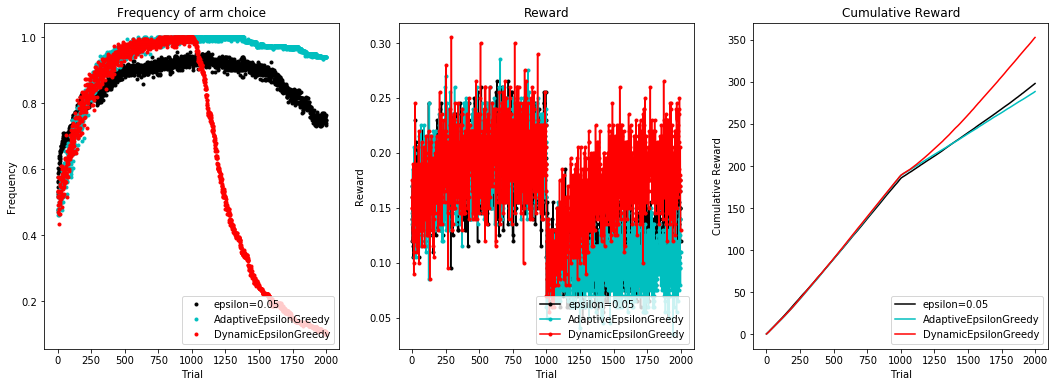

In [10]:
class DynamicEpsilonGreedy(AdaptiveEpsilonGreedy):
    
    def update(self, arm, reward):
        """Update an arm with the reward"""
        self.counts[arm] = self.counts[arm] + 1
        n = self.counts[arm]
        # New experiences will represent at least 100th of the running value estimation
        if n > 100:
            n = 100
        value = self.values[arm]
        self.values[arm] = ((n - 1) / n) * self.values[arm] + (1/n) * reward

    
    
fig, axes = plt.subplots(1,3, figsize=(18,6))
        
model = DynamicModel(EpsilonGreedy, {'n_arms': 2, 'epsilon':0.05}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='k', label='epsilon=0.05')


model = DynamicModel(AdaptiveEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='c', label='AdaptiveEpsilonGreedy')


model = DynamicModel(DynamicEpsilonGreedy, {'n_arms': 2, 'epsilon':1.00}, weights=[0.1, 0.2], size=2000)
model.repeat_simulation()
plot_summary(model, axes, color='r', label='DynamicEpsilonGreedy')

plt.show()